# Opus 13001
## The song of a lonely buoy
### By Electronick

The objective is to create music out of a buoy parameters.

The objective is to experiment with different forms of quantize data to make it into music.

This notebook uses:
1. NOAA National Data Buoy Center (NDBC) api, with the python library [NDBC-api](https://pypi.org/project/ndbc-api/)
2. Reaper music software to get the midi and play it with
3. [BBC's Symphony Orchestra Discover VST](https://www.spitfireaudio.com/bbc-symphony-orchestra-discover#overview)

### Step # 1: from data to music?

How to transform data into music that makes sense?
I' m not sure, but let's figure it out together

What is the basis of music?
with the help of claude 3.5, we get the following:

The fundamental elements of music include:

1. Pitch: The highness or lowness of a sound, represented by notes.

2. Rhythm: The pattern of regular or irregular pulses in music, including:
   - Beat: The steady pulse in music
   - Tempo: The speed of the beat
   - Meter: The organization of beats into regular groupings

3. Melody: A sequence of notes that form a recognizable tune.

4. Harmony: The combination of simultaneously sounded notes to create chords and chord progressions.

5. Timbre: The quality or color of a sound that distinguishes different voices or instruments.

6. Dynamics: The variation in loudness or softness of sound.

7. Texture: The way different musical elements are combined and interrelated.

8. Form: The overall structure or organization of a musical piece.

9. Scales: Sequences of notes in a specific pattern, such as major, minor, pentatonic, etc.

10. Intervals: The distance between two pitches.

11. Key: The central note or chord that a piece of music is built around.

12. Time signatures: Indications of the number of beats in each measure and which note value represents one beat.

13. Articulation: The way individual notes are played or sung (e.g., staccato, legato).

14. Tonality: The system of relationships between different pitches, often centered around a tonic or home note.

15. Modulation: The process of changing from one key to another within a piece of music.

These elements combine to create the complex and diverse world of music across various genres and styles.

### Test # 1
Sure sure... but let's start with the basic.

we can normalize data into 2 octaves (to make it more interesting, i guess.)
We can play with the scale of C Mayor, as is the most straightforwards in terms of musical notes.
plug that into midi, and into reaper, and see what happens!

In [13]:
%pip install ndbc-api
%pip install mido python-rtmidi

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [15]:
from ndbc_api import NdbcApi

import mido
import time

import pandas as pd
import matplotlib.pyplot as plt

api = NdbcApi()

Get data from buoy 13001 and remove the columns with nulls

In [5]:
df = api.get_data(
    station_id='13001',
    mode='stdmet',
    start_time='2023-09-01',
    end_time='2024-09-02',
)
# Removing columns where all values are NaN
df = df.dropna(axis=1, how='all')

df

,WDIR,WSPD,GST,PRES,ATMP,WTMP
timestamp,,,,,,
2024-07-20 00:00:00,207,5.8,7.0,1016.3,26.2,27.6
2024-07-20 01:00:00,220,6.3,7.5,1015.9,26.6,27.6
2024-07-20 02:00:00,228,6.4,7.4,1015.3,26.7,27.5
2024-07-20 03:00:00,217,7.0,9.1,1014.7,26.8,27.5
2024-07-20 04:00:00,224,6.8,8.0,1014.6,26.8,27.4
...,...,...,...,...,...,...
2024-09-01 20:00:00,244,4.3,5.0,1011.4,27.8,28.3
2024-09-01 21:00:00,254,4.1,4.9,1012.3,27.9,28.2
2024-09-01 22:00:00,255,3.6,4.5,1013.1,28.0,28.3


Let's plot WTMP (water temperature)

In [8]:
min_wtmp = df['WTMP'].min()
max_wtmp = df['WTMP'].max()

print("Min wtmp:", min_wtmp)
print("Max wtmp:", max_wtmp)

# Normalize to range 0-1
df['music_wtmp'] = (df['WTMP'] - min_wtmp) / (max_wtmp - min_wtmp)

# Scale to range 1-16
df['music_wtmp'] = df['music_wtmp'] * 16

# Round to nearest integer
df['music_wtmp'] = df['music_wtmp'].round().astype(int)

# Display the DataFrame
print(df[['WTMP', 'music_wtmp']])



Min wtmp: 27.2
Max wtmp: 29.6
                     WTMP  music_wtmp
timestamp                            
2024-07-20 00:00:00  27.6           3
2024-07-20 01:00:00  27.6           3
2024-07-20 02:00:00  27.5           2
2024-07-20 03:00:00  27.5           2
2024-07-20 04:00:00  27.4           1
...                   ...         ...
2024-09-01 20:00:00  28.3           7
2024-09-01 21:00:00  28.2           7
2024-09-01 22:00:00  28.3           7
2024-09-01 23:00:00  28.3           7
2024-09-02 00:00:00  28.3           7

[1057 rows x 2 columns]


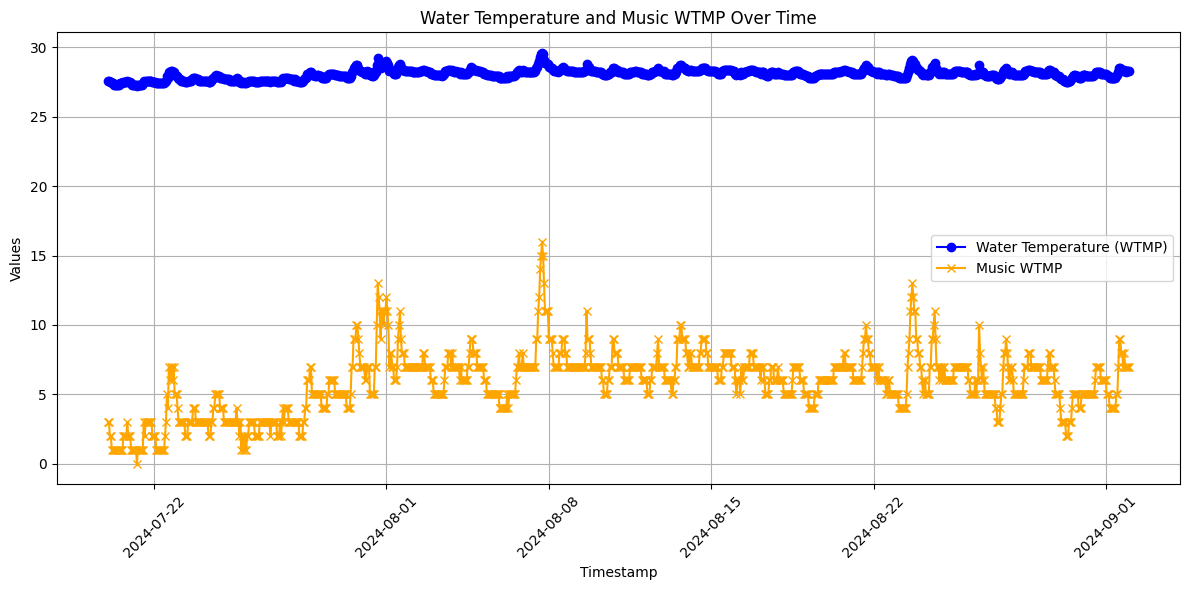

In [11]:
# Plotting the data
plt.figure(figsize=(12, 6))

# Plot WTMP
plt.plot(df.index, df['WTMP'], label='Water Temperature (WTMP)', color='blue', marker='o')

# Plot music_wtmp
plt.plot(df.index, df['music_wtmp'], label='Music WTMP', color='orange', marker='x')

# Adding titles and labels
plt.title('Water Temperature and Music WTMP Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

Configure the midi virtual port. I used loopmidi in windows, and created a midi virtual channel called Python2Reaper
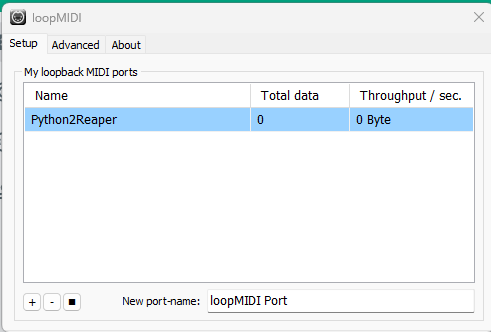

In [16]:
print("Output ports:", mido.get_output_names())
print("Input ports:", mido.get_input_names())

Output ports: ['Microsoft GS Wavetable Synth 0', 'Python2Reaper 1']
Input ports: ['Python2Reaper 0']


In [22]:
# Define the MIDI port (you may need to adjust this)
port_name = 'Python2Reaper 1'

# Create a MIDI output
outport = mido.open_output(port_name)

In [37]:

# Define the duration of each note (in seconds)
duration = 0.3

for index, row in df.iloc[:50].iterrows():
    print(f"Index: {index}, note:: {row['music_wtmp']}")
    note = int(row['music_wtmp']) + 60
    
    # Note On message
    msg_on = mido.Message('note_on', note=note, velocity=64, channel=0)
    outport.send(msg_on)
    
    msg_on = mido.Message('note_on', note=note+5, velocity=64, channel=1)
    outport.send(msg_on)
    
    # Wait for the duration
    time.sleep(duration)
    
    # Note Off message
    msg_off = mido.Message('note_off', note=note, velocity=64, channel=0)
    outport.send(msg_off)
    
    msg_off = mido.Message('note_off', note=note+5, velocity=64, channel=1)
    outport.send(msg_off)

Index: 2024-07-20 00:00:00, note:: 3.0
Index: 2024-07-20 01:00:00, note:: 3.0
Index: 2024-07-20 02:00:00, note:: 2.0
Index: 2024-07-20 03:00:00, note:: 2.0
Index: 2024-07-20 04:00:00, note:: 1.0
Index: 2024-07-20 05:00:00, note:: 1.0
Index: 2024-07-20 06:00:00, note:: 1.0
Index: 2024-07-20 07:00:00, note:: 1.0
Index: 2024-07-20 08:00:00, note:: 1.0
Index: 2024-07-20 09:00:00, note:: 1.0
Index: 2024-07-20 10:00:00, note:: 1.0
Index: 2024-07-20 11:00:00, note:: 1.0
Index: 2024-07-20 12:00:00, note:: 1.0
Index: 2024-07-20 13:00:00, note:: 1.0
Index: 2024-07-20 14:00:00, note:: 1.0
Index: 2024-07-20 15:00:00, note:: 1.0
Index: 2024-07-20 16:00:00, note:: 2.0
Index: 2024-07-20 17:00:00, note:: 2.0
Index: 2024-07-20 18:00:00, note:: 2.0
Index: 2024-07-20 19:00:00, note:: 2.0
Index: 2024-07-20 20:00:00, note:: 3.0
Index: 2024-07-20 21:00:00, note:: 2.0
Index: 2024-07-20 22:00:00, note:: 2.0
Index: 2024-07-20 23:00:00, note:: 2.0
Index: 2024-07-21 00:00:00, note:: 1.0
Index: 2024-07-21 01:00:0

In [ ]:
# Close the port
outport.close()